## Spec2Pipeline for LRS-SLIT   (MIRI LRS-SLIT CALSPEC2) for point source

`Spec2Pipeline` applies additional instrumental corrections and calibrations to count rate products that result in a fully calibrated individual exposure.

Official documentation for `Spec2Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html>

The `Spec2Pipeline` for LRS-SLIT comprises a linear series of steps. The steps in order are:

|Step|Description|
|:---|:---|
|`assign_wcs`|attach WCS object to each science exposure|
|`background`|subtract dedicated background exposures|
|`srctype`|if APT source type set to 'UNKNOWN', sets the 'SRCTYPE' keyword to 'EXTENDED' for MRS|
|`flat_field`|correct the exposure using the flat-field reference file|
|`photom`|apply flux (photometric) calibration|
|`extract_1d`|extract 1D spectrum from 3D cube|


### Input data

An example of running the file through the `Spec2Pipeline` is now shown using a simple simulated fullband, 2-point dither observation of a point source (power law plus emission lines spectrum) with the MIRI LRS-SLIT produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public) and brought to level 2A using the `Detector1Pipeline`.

#### Imports

In [3]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

`Spec2Pipeline` can be run by passing indivual exposures or datamodels but in this sample case we produce an association file so all can be run through `Spec2Pipeline` in a single call. It is assumed that the science file are in 'LRS-SLIT_point_source/science' and the background file is in 'LRS-SLIT_point_source/background'.

In [4]:
# load the science and background files to lists
my_science_files = glob.glob('LRS-SLIT_point_source/science/*rate.fits')
my_background_files = glob.glob('LRS-SLIT_point_source/background/*rate.fits')
my_science_files = sorted(my_science_files)

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, rule=DMSLevel2bBase)
asn.data['products'] = None

# set the association name
asn_name = 'my_point_source'

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'spec2'

for n, sci in enumerate(my_science_files):
    asn.new_product('{}_dither{}'.format(asn_name, str(n+1)))
    sci_member = Member({'expname': sci, 'exptype': 'science'})    
    new_members = asn.current_product['members']
    new_members.append(sci_member)
    
    for bkg in my_background_files:
        bkg_member = Member({'expname': bkg, 'exptype': 'background'})
        new_members.append(bkg_member)
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl2_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "spec2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.17.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "my_point_source_pool",
    "products": [
        {
            "name": "my_point_source_dither1",
            "members": [
                {
                    "expname": "LRS-SLIT_point_source/science/det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "LRS-SLIT_point_source/background/det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        }
    ]
}


Import Spec2Pipeline and print the docstring to show some information

In [5]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


The association file is passed as input. The output level 2B files will be saved in `my_output_dir` as `_cal.fits`. The cubes and 1D spectra will also be saved.

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output

`steps` : dict, optional, default None  
&nbsp;&nbsp;&nbsp;&nbsp; pass parameters to steps
    
The output filenames will be determined by the `asn_name` in the association file which was set in the cell above.



In [6]:
# user specified
my_output_dir = 'LRS-SLIT_science'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Spec2Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir)


2020-10-16 11:44:51,049 - CRDS - ERROR -  Error determining best reference for 'pars-backgroundstep'  =   Unknown reference type 'pars-backgroundstep'
2020-10-16 11:44:51,095 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-10-16 11:44:51,143 - CRDS - ERROR -  Error determining best reference for 'pars-imprintstep'  =   Unknown reference type 'pars-imprintstep'
2020-10-16 11:44:51,190 - CRDS - ERROR -  Error determining best reference for 'pars-msaflagopenstep'  =   Unknown reference type 'pars-msaflagopenstep'
2020-10-16 11:44:51,236 - CRDS - ERROR -  Error determining best reference for 'pars-extract2dstep'  =   Unknown reference type 'pars-extract2dstep'
2020-10-16 11:44:51,287 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-10-16 11:44:51,333 - CRDS - ERROR -  Error determining best reference for 'pars-pathlossstep'  =   

2020-10-16 11:44:52,269 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2020-10-16 11:44:52,294 - CRDS - INFO -  Fetching  /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0007.fits  262.1 K bytes  (1 / 5 files) (0 / 13.0 M bytes)
2020-10-16 11:44:53,860 - CRDS - INFO -  Fetching  /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json      745 bytes  (2 / 5 files) (262.1 K / 13.0 M bytes)
2020-10-16 11:44:54,319 - CRDS - INFO -  Fetching  /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat

2020-10-16 11:45:00,950 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-10-16 11:45:00,951 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2020-10-16 11:45:00,952 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2020-10-16 11:45:01,008 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits>,).
2020-10-16 11:45:01,010 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_result

2020-10-16 11:45:02,104 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits
2020-10-16 11:45:02,141 - stpipe.Spec2Pipeline.resample_spec - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,

2020-10-16 11:45:02,249 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling slit None (387, 44)
2020-10-16 11:45:02,918 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)
2020-10-16 11:45:02,958 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  179.999087909 -0.000075806 180.000404817 -0.000075806 180.000404817 0.000033658 179.999087909 0.000033658
2020-10-16 11:45:03,112 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in LRS-SLIT_scien

[<ImageModel(1024, 1032) from my_point_source_dither1_cal.fits>]

We can plot the extracted spectrum using the x1d.fits file in the output directory 

2020-10-16 11:53:54,303 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



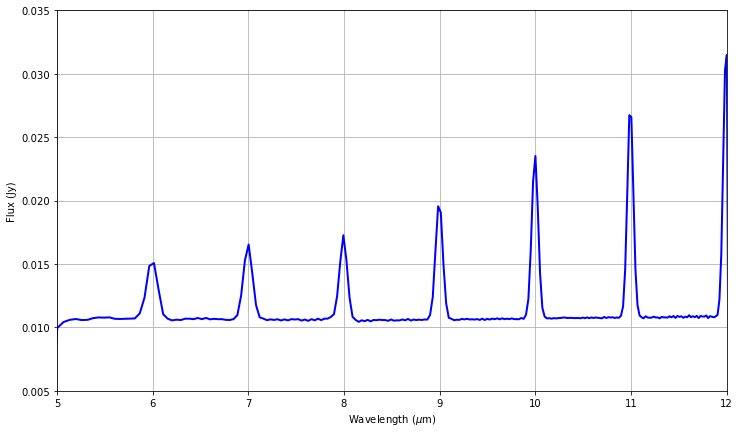

In [12]:
# read the file to datamodel
spec_file = glob.glob(os.path.join(my_output_dir,"*x1d.fits"))[0]
dm = datamodels.open(spec_file)

fig, axs = plt.subplots(1, 1, figsize=(12, 7))

# plot the spectrum 
axs.plot(dm.spec[0].spec_table['WAVELENGTH'][1:-1], dm.spec[0].spec_table['FLUX'][1:-1], c='b', marker='.', 
         markersize=0, linestyle='-', linewidth=2)
axs.set_ylabel(r'Flux (Jy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')
axs.set_xlim(5.0,12.0)
axs.set_ylim(0.005,0.035)
plt.grid()
plt.show()

### Further examples

Other notebooks with more complex examples can be found here:

*To be added*